## Early Warning System for Corporate Distress

ECE 143 - Group 14

Team Members: Kendra Chen, Zhuosheng Song, Matthew Alegrado, Jinglin Cao

This notebook presents a comprehensive analysis of Company Bankruptcy Prediction in Taiwan dataset, investigating financial indicators that signal corporate distress. The objective is to construct a robust predictive pipeline capable of identifying firms at elevated risk of bankruptcy.

## 1.1 Primary Task

**Main task**: Build a model pipeline to assess company distress using financial indicators.

We propose a pipeline consisting of PCA-based feature engineering and selection, followed by VIF pruning to remove multicollinearity, then training a classification model to determine whether a company is likely to experience distress given its current business statistics. The pipeline also derives interpretable decision thresholds with SHAP analysis and monitoring rules based on influential financial indicators and visualizes model explanations.

## 1.2 Evaluation Strategy

Multiple evaluation metrics are applied to assess prediction quality and interpretability:

- **ROC-AUC**: Measures the model's ability to distinguish bankrupt from non‑bankrupt firms across all classification thresholds.

- **PR-AUC**: Evaluates precision and recall for the minority class, emphasizing correct detection of bankruptcies.

- **F1 Score**: Balances precision and recall, providing a single metric for detecting bankrupt firms.

Given the dataset's extreme class imbalance (approximately 3% bankrupt vs. 97% non‑bankrupt firms), the F1 score provides a more reliable indicator of model performance than accuracy. Models that ignore minority cases may achieve high accuracy while failing to detect distress, making F1 the metric of primary interest.

## 1.3 Baseline Approach

We define two baseline models to provide reference performance:

- Naive baseline: Predicts all companies as non-bankrupt. While this achieves high overall accuracy, it fails to detect any bankrupt firms, resulting in an F1 score of zero.

- Insight-based baseline: Select a small set of financial ratios from the literature that are historically associated with bankruptcy. This tests the predictive power of well-known indicators.

### 1.4 Validity Assessment

Model validity is established by confirming that performance on a held‑out test set reflects true generalization. No test data was accessed prior to final evaluation. The following controls were applied:

- 70%/15%/15% Train valid test separation with no overlap or leakage.

- Imbalance handling: SMOTE and selective oversampling to address the 3% bankruptcy rate

- Generalization checks: Confusion matrix inspection and feature importance review to ensure predictions align with financial intuition

These measures ensure that reported performance is reliable and driven by meaningful financial signals rather than artifacts or leakage.

## Imports and setup

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)

from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import shap

In [2]:
# ------------------------------
# Config
# ------------------------------
RANDOM_STATE = 42
TEST_SIZE = 0.3
VIF_THRESHOLD = 5
MISSING_DROP_THRESHOLD = 0.40
WINSOR_LOWER = 0.01
WINSOR_UPPER = 0.99
ABNORMAL_THRESH = 3
CORRELATION_THRESH = 0.15
MAX_ZERO_FRACTION = 0.2

INPUT_CSV = "./data/data.csv"   # raw input file
OUTPUT_DIR = "artifacts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Data Collection & Preprossing

### Data Collection

**Source**: Company Bankruptcy Prediction

**URL**: [https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction/data](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction/data)

**References**:
- [Bankruptcy Detection](https://www.kaggle.com/code/marto24/bankruptcy-detection)


In [3]:
# Read into pandas dataframe
df_companies = pd.read_csv(INPUT_CSV)

print(f"\nLoaded {len(df_companies)} entries.")


Loaded 6819 entries.


### Data Preprocessing

**Processing Steps**:
- Fix messy column names to make it easier to work with
- Convert everything to numbers, since models can't handle text
- Remove duplicate entries
- Drop columns with too many missing values (or 0 zeros)
- Drop columns that have abnormally big values
- Clip extreme outliers, this stops crazy ratios from breaking things
- Remove zero variance columns, since there's no useful data there

In [4]:
# Basic cleaning steps
df = df_companies.copy()

# Fix column names a bit
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace('[^A-Za-z0-9]+', '_', regex=True)
df.columns = df.columns.str.lower()
df = df.rename(columns={'bankrupt_': 'bankrupt'})

# Additional cleaning
df = df.apply(pd.to_numeric, errors="coerce")
df = df.drop_duplicates()
df = df.dropna(axis=1, thresh=int((1 - MISSING_DROP_THRESHOLD) * len(df)))

# Clip outliers
for col in df.columns:
    if col == "bankrupt":
        continue
    lo, hi = df[col].quantile(WINSOR_LOWER), df[col].quantile(WINSOR_UPPER)
    df[col] = np.clip(df[col], lo, hi)

# Drop columns with no variation
df = df.loc[:, df.std() > 0]

# Check for bad columns
bad_cols = []
for col in df.columns:
    if col == "bankrupt":
        continue
    if (df[col].abs() >= ABNORMAL_THRESH).any():
        bad_cols.append(col)
    if (df[col] == 0).mean() >= MAX_ZERO_FRACTION:
        bad_cols.append(col)

print("Dropping:", bad_cols)
df = df.drop(columns=bad_cols)

print("Final shape:", df.shape)

Dropping: ['operating_expense_rate', 'research_and_development_expense_rate', 'research_and_development_expense_rate', 'interest_bearing_debt_interest_rate', 'tax_rate_a_', 'total_asset_growth_rate', 'inventory_turnover_rate_times_', 'fixed_assets_turnover_frequency', 'inventory_current_liability', 'long_term_liability_to_current_assets', 'long_term_liability_to_current_assets', 'current_asset_turnover_rate', 'quick_asset_turnover_rate', 'cash_turnover_rate']
Final shape: (6819, 82)


## EDA

Here, we try to understand data distributions and identify patterns so that they can hopefully guide our modeling decisions.

In [5]:
# Basic info
print("Dataset Info:")
print(df_companies.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    Aft

counts:
bankrupt
0    6599
1     220
Name: count, dtype: int64
percentages:
bankrupt
0    96.77372
1     3.22628
Name: count, dtype: float64


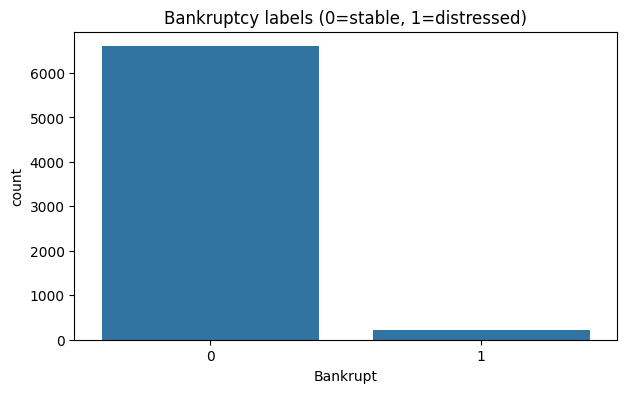

In [ ]:
# Check bankruptcy target distribution
counts = df['bankrupt'].value_counts()
perc = counts / len(df) * 100

print("counts:")
print(counts)
print("percentages:")
print(perc)

# Plot the distribution
plt.figure(figsize=(7,4))
sns.countplot(x='bankrupt', data=df)
plt.xlabel("Bankrupt")
plt.title("Bankruptcy labels (0=stable, 1=distressed)")
plt.savefig(os.path.join(OUTPUT_DIR, "bankruptcy_labels.png"), dpi=200)
plt.show()
plt.close()


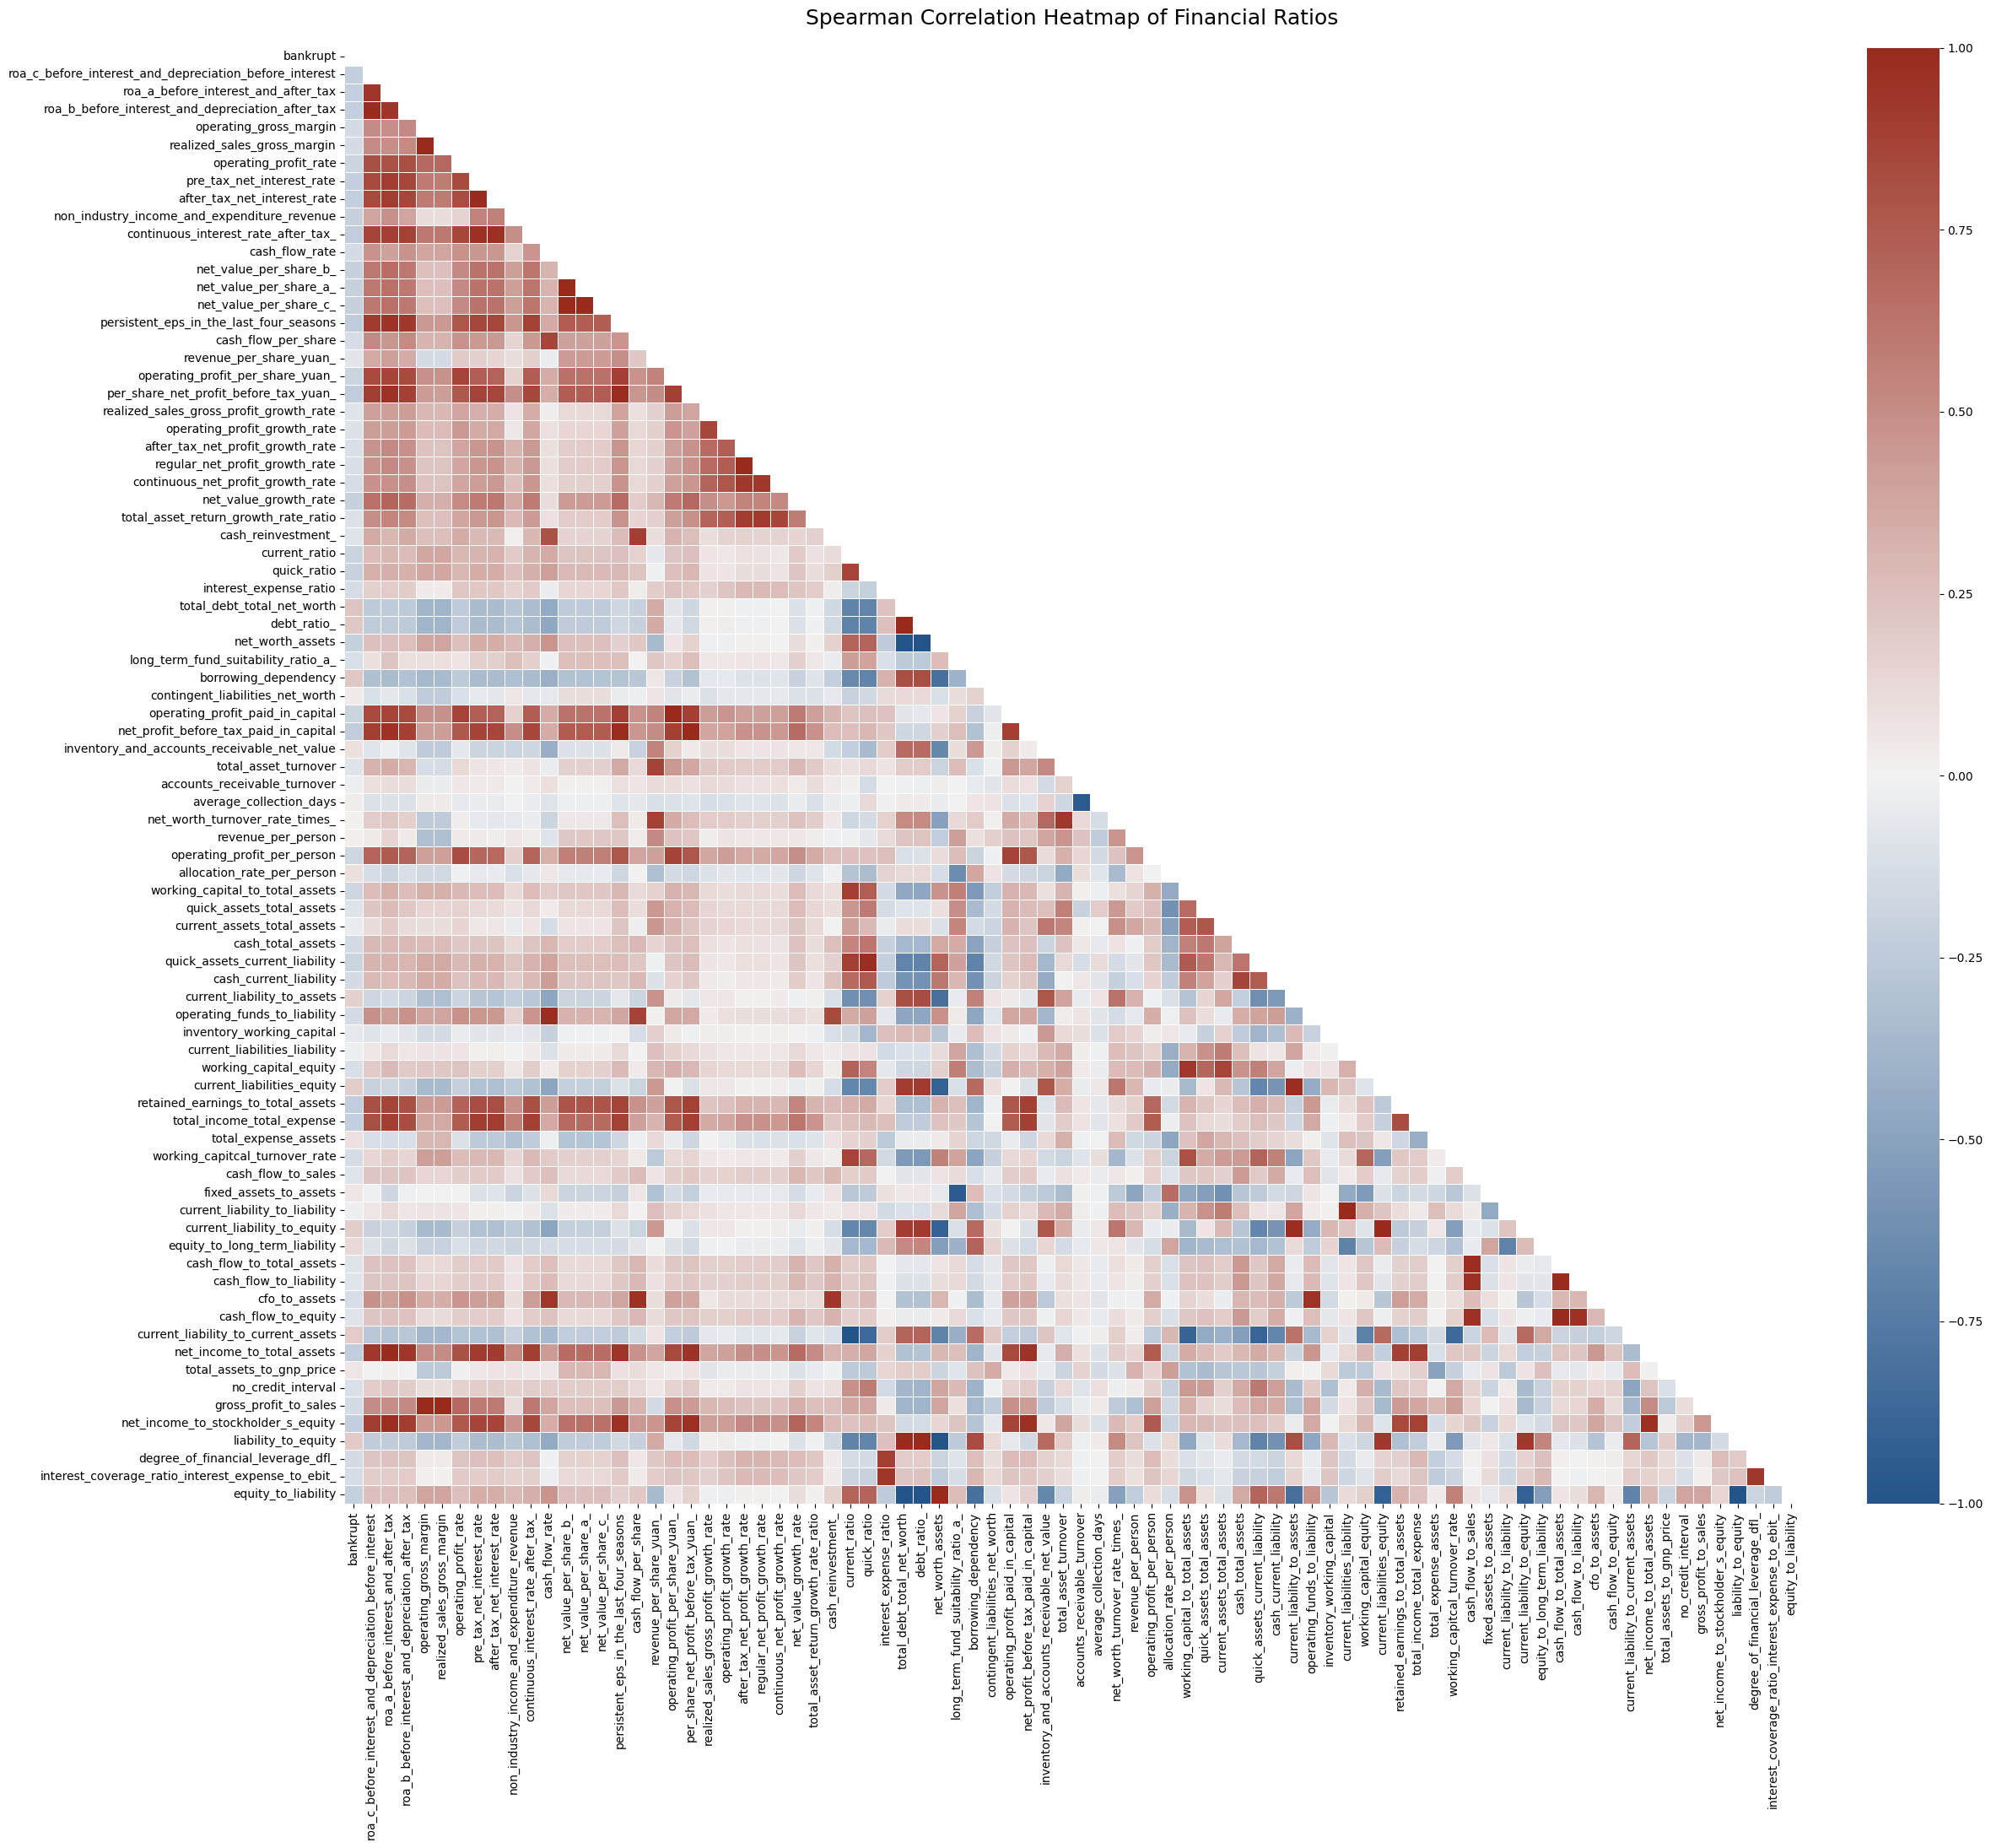

In [7]:
# Spearman correlation heatmap
corr_matrix = df.corr(method='spearman')

fig, ax = plt.subplots(figsize=(28, 22))
upper_triangle = np.triu(np.ones(corr_matrix.shape, dtype=bool))

palette = sns.diverging_palette(250, 15, s=85, l=35, as_cmap=True)

sns.heatmap(
    corr_matrix,
    mask=upper_triangle,
    cmap=palette,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.4,
    cbar_kws={"fraction": 0.045, "pad": 0.03}
)

ax.set_title("Spearman Correlation Heatmap of Financial Ratios", fontsize=18, pad=20)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "correlation_heatmap.png"), dpi=200)
plt.show()
plt.close()

Conclusion: The Spearman correlation heatmap visually confirms the presence of extensive multicollinearity within the dataset, as evidenced by large, contiguous blocks of ratios displaying strong positive (dark red) and negative (dark blue) correlations. This high degree of inter-correlation demonstrates significant redundancy among the financial features.

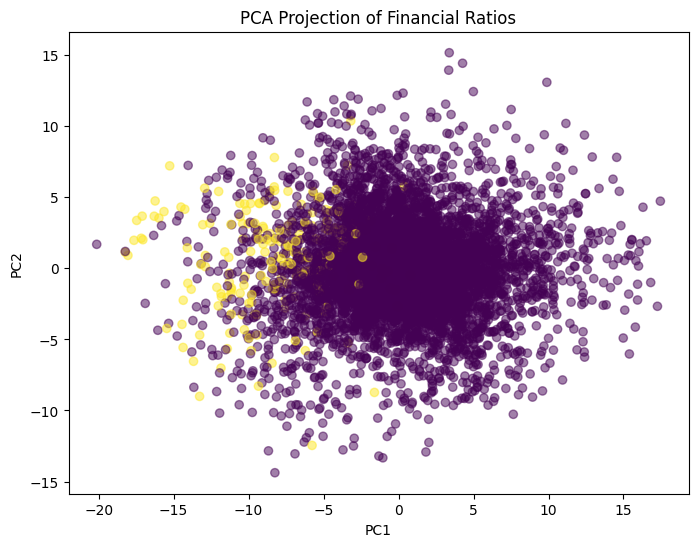

In [ ]:
# PCA scatter plot

# Split features and target
X = df.drop("bankrupt", axis=1)
y = df["bankrupt"]

# Scale features, run PCA
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2).fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(pca[:,0], pca[:,1], c=y, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Financial Ratios")
plt.savefig(os.path.join(OUTPUT_DIR, "pca_projection.png"), dpi=200)
plt.show()
plt.close()


PCA was applied to reduce the financial ratios into two dimensions for easier visualization. The features were standardized so each ratio contributed on the same scale, then transformed into two principal components. PC1 reflects the strongest source of variation in the data, while PC2 captures the next most important pattern, orthogonal to PC1. Each point in the scatter plot represents a company, with color indicating bankruptcy status (0 = healthy, 1 = bankrupt). The projection highlights how firms separate along the main axis of financial condition, with secondary structure visible on the second axis.


Conclusion: The PCA scatter plot demonstrates that high multicollinearity among financial ratios results in a single dense cluster, rendering linear principal components ineffective at distinguishing bankrupt from non-bankrupt firms.

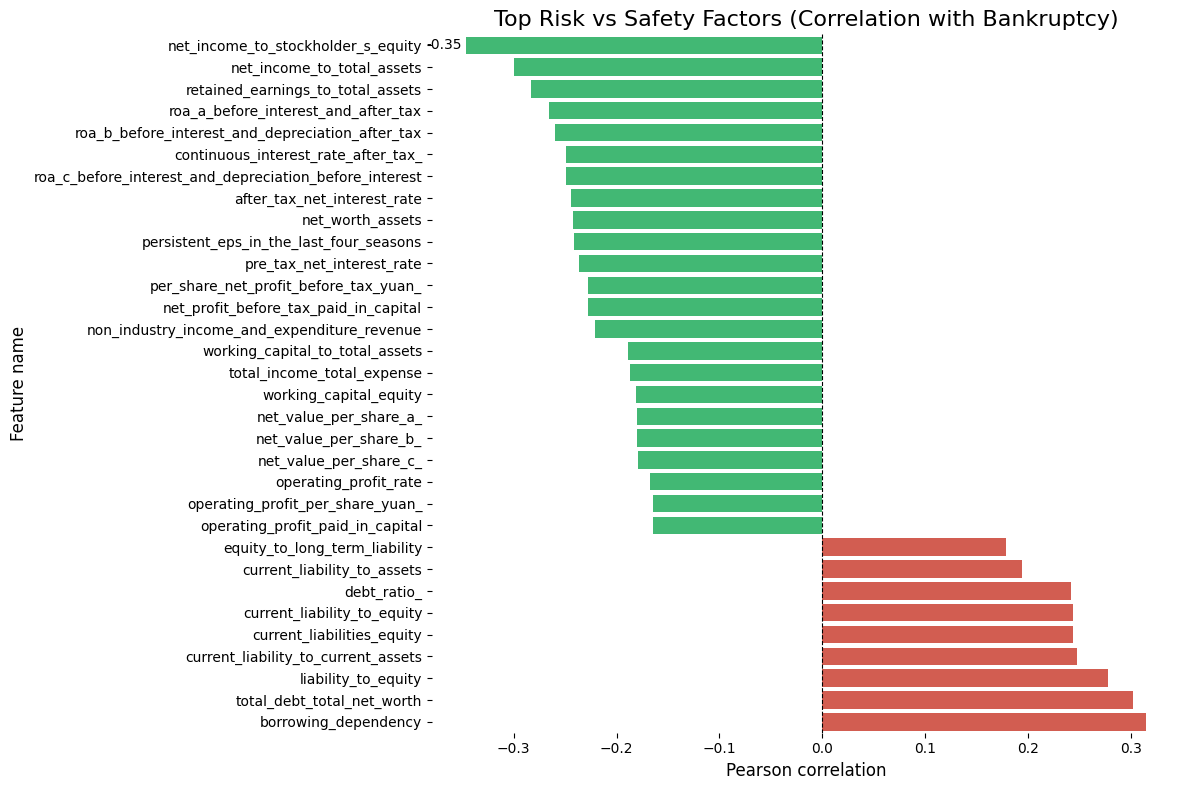

In [ ]:
# Correlations with bankruptcy
corr = df.corr()['bankrupt'].drop('bankrupt')

# Select features with strong positive/negative correlation
risk = corr[corr >= CORRELATION_THRESH].sort_values(ascending=False)
safe = corr[corr <= -CORRELATION_THRESH].sort_values()
top_corr = pd.concat([risk, safe]).sort_values()

# Plot bar chart
plt.figure(figsize=(12,8))
colors = ['#e74c3c' if v > 0 else '#2ecc71' for v in top_corr.values]
ax = sns.barplot(x=top_corr.values, y=top_corr.index, palette=colors)

ax.bar_label(ax.containers[0], fmt="%.2f", padding=3)
plt.axvline(0, color="black", lw=0.8, ls="--")
plt.title("Top Risk vs Safety Factors (Correlation with Bankruptcy)", fontsize=16)
plt.xlabel("Pearson correlation", fontsize=12)
plt.ylabel("Feature name", fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "risk_safety_factors.png"), dpi=200)
plt.show()
plt.close()


Conclusion: This cell shows the financial ratios that are most strongly correlated with bankruptcy. Positive ones (red bars) are risk factors, indicating higher likelihood of bankruptcy. The strongest risk signal is borrowing dependency, while the most protective risk factor is net income to stockholder equity.

## Modeling and Evaluation

First, we prepare the train/test data for the baseline model

In [10]:
# Train/Test split
y = df["bankrupt"]
X = df.drop(columns=["bankrupt"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

**Baseline 1: Naive baseline**

In [11]:
# Naive baseline uses the default prediction of not bankrupt
y_pred = [0] * len(y_test)

print("\nClassification Report (F1-optimized threshold):")
print(classification_report(y_test, y_pred, digits=3))


Classification Report (F1-optimized threshold):
              precision    recall  f1-score   support

           0      0.968     1.000     0.984      1980
           1      0.000     0.000     0.000        66

    accuracy                          0.968      2046
   macro avg      0.484     0.500     0.492      2046
weighted avg      0.937     0.968     0.952      2046



Conclusion: The naive baseline assumes every company is not bankrupt. As seen above, this leads to a very high accuracy (96.8%), but the result is misleading. Notice that the recall and F1 score are zero, reflecting the fact that the model is unable to accurately identify any bankruptcy cases.

**Baseline 2: Insight based forecasting**

In [12]:
# Pick common ratios
DOMAIN_FEATURES = [
    "current_ratio",
    "quick_ratio",
    "working_capital_to_total_assets",
    "retained_earnings_to_total_assets",
    "ebit_to_total_assets",
    "market_value_of_equity_to_total_liabilities",
    "sales_to_total_assets",
    "cash_flow_to_liability",
    "cash_flow_to_assets",
    "net_income_to_total_assets",
    "liability_to_equity",
]

# Only keep features that exist in the df
selected_features = [c for c in DOMAIN_FEATURES if c in df.columns]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    df[selected_features], y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

Random Forest Metrics
ROC-AUC: 0.9112526782981328
PR-AUC: 0.3438596170286877
              precision    recall  f1-score   support

           0      0.971     0.997     0.984      1980
           1      0.545     0.091     0.156        66

    accuracy                          0.968      2046
   macro avg      0.758     0.544     0.570      2046
weighted avg      0.957     0.968     0.957      2046



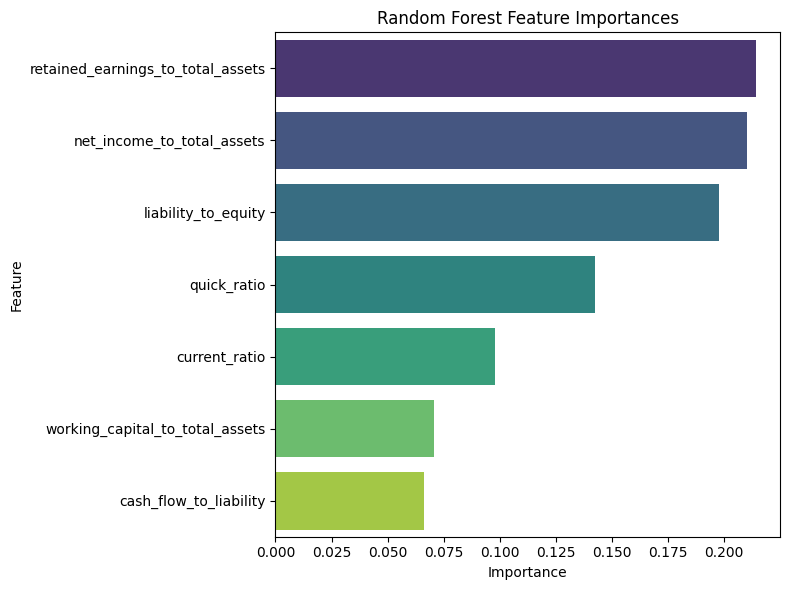

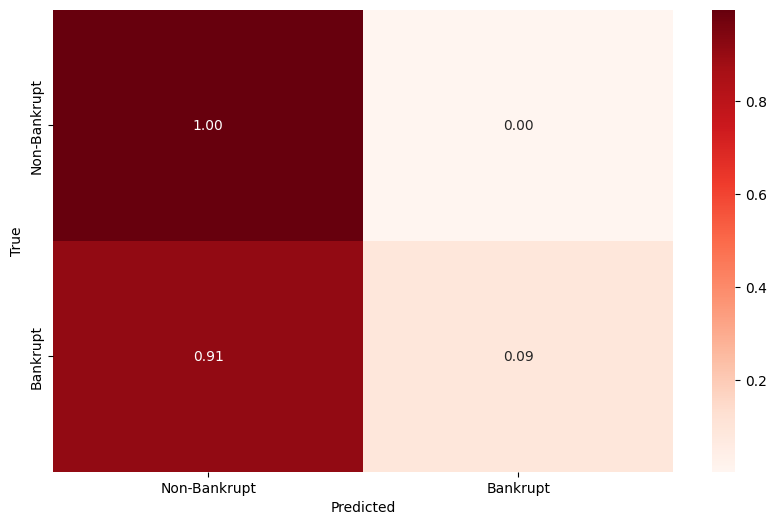

In [ ]:
# Random Forest model
rf = RandomForestClassifier(
    n_estimators=800,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Metrics")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC:", average_precision_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf, digits=3))

# Feature importances
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=rf_importances.values, y=rf_importances.index, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "random_forest_importance.png"), dpi=200)
plt.show()
plt.close()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
cm_rates = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

labels = ["Non-Bankrupt", "Bankrupt"]
plt.figure(figsize=(10,6))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(OUTPUT_DIR, "insight_baseline_confusion_matrix.png"), dpi=200)
plt.show()
plt.close()


Conclusion: The Random Forest model has high accuracy (96.8%) and good ROC-AUC (0.91). However, it is still a weak predictor of bankruptcy, much like the naive case. Recall is 0.09 and the F1 score is 0.15. Most bankrupt companies are not identified by the model. The Random Forest model improves upon the naive baseline, but it still needs to be better at identifying bankrupt companies.

**Improved Model**

Feature Engineering

We chose to select features that have highest absolute correlation with bankrupt, plus manually selected features if they were not already in the feature columns.

In [14]:
# Features from correlation
corr_features = set(top_corr.index)

# Add domain ones if they exist
manual_additions = [f for f in DOMAIN_FEATURES if f in df.columns and f not in corr_features]

candidate_features = sorted(corr_features.union(manual_additions))

print("Corr-selected features:", len(corr_features))
print("Manual domain features:", manual_additions)
print("Total candidate features:", len(candidate_features))

Corr-selected features: 32
Manual domain features: ['current_ratio', 'quick_ratio', 'cash_flow_to_liability']
Total candidate features: 35


By applying VIF pruning, we remove features that convey overlapping information, ensuring that the remaining predictors are not redundant and reducing multicollinearity before model training.

In [15]:
# VIF-based iterative pruning
from utils.vif import reduce_vif_ratio

X_reduced, vif_drops = reduce_vif_ratio(df[candidate_features], ratio=VIF_THRESHOLD)

print("\nFinal feature set after VIF reduction:")
for c in X_reduced.columns:
    print("  -", c)

/Users/dwertyu/.venv-311/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropped 'current_liabilities_equity' with VIF=inf (> 359.68 = 5×median).
Dropped 'net_worth_assets' with VIF=87698743.52 (> 331.39 = 5×median).
Dropped 'after_tax_net_interest_rate' with VIF=785584846.10 (> 57405.51 = 5×median).
Dropped 'continuous_interest_rate_after_tax_' with VIF=115827493.65 (> 56815.14 = 5×median).
Dropped 'pre_tax_net_interest_rate' with VIF=39171040.03 (> 55360.53 = 5×median).
Dropped 'operating_profit_rate' with VIF=3417252.33 (> 46375.16 = 5×median).
Dropped 'non_industry_income_and_expenditure_revenue' with VIF=911590.37 (> 37333.64 = 5×median).
Dropped 'net_income_to_stockholder_s_equity' with VIF=492186.27 (> 36461.38 = 5×median).
Dropped 'current_liability_to_equity' with VIF=414416.96 (> 35529.39 = 5×median).
Dropped 'net_value_per_share_a_' with VIF=229671.83 (> 33983.84 = 5×median).
Dropped 'liability_to_equity' with VIF=67227.51 (> 32100.56 = 5×median).
Dropped 'net_value_per_share_b_' with VIF=56853.17 (> 27985.47 = 5×median).
Dropped 'working_capital

In [16]:
# Chosen features
X_reduced.columns.tolist()

['cash_flow_to_liability',
 'current_liability_to_assets',
 'current_liability_to_current_assets',
 'current_ratio',
 'debt_ratio_',
 'net_value_per_share_c_',
 'operating_profit_per_share_yuan_',
 'per_share_net_profit_before_tax_yuan_',
 'quick_ratio',
 'roa_c_before_interest_and_depreciation_before_interest',
 'total_debt_total_net_worth',
 'total_income_total_expense',
 'working_capital_to_total_assets']

In [17]:
# Train/Valid/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_reduced, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("\nTrain/Valid/Test shapes:")
print("X_train:", X_train.shape, "   X_val:", X_val.shape, "   X_test:", X_test.shape)


Train/Valid/Test shapes:
X_train: (4773, 13)    X_val: (1023, 13)    X_test: (1023, 13)


Augment negative samples to mitigate skewness

In [18]:
# Negative Sample Augmentation (Hard Negatives)

from utils.feature_engineering import augment_negative_samples

X_train_aug, y_train_aug = augment_negative_samples(
    X_train, y_train,
    factor=1.0,        # create 100% more hard negatives
    noise_scale=0.1,  # noise intensity
    random_state=RANDOM_STATE
)

print("After negative augmentation:", np.bincount(y_train_aug))

After negative augmentation: [9238  154]


SMOTE oversampling

In [19]:
# SMOTE Oversampling for Class (bankrupt=1)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train_aug, y_train_aug)

print("After SMOTE balancing:", np.bincount(y_train_bal))

After SMOTE balancing: [9238 9238]



=== Improved Model Metrics ===
ROC-AUC: 0.893939393939394
PR-AUC: 0.3872057797760116
              precision    recall  f1-score   support

           0      0.986     0.969     0.977       990
           1      0.380     0.576     0.458        33

    accuracy                          0.956      1023
   macro avg      0.683     0.772     0.717      1023
weighted avg      0.966     0.956     0.960      1023



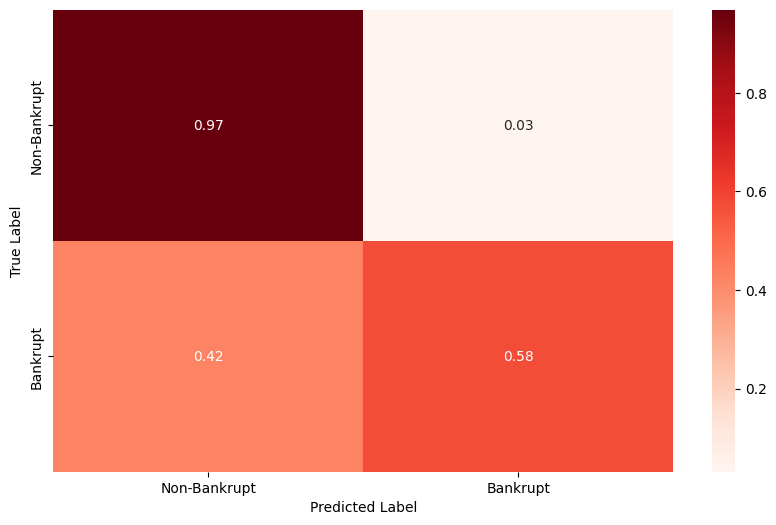

In [20]:
# Random Forest With SHAP
model_shap = RandomForestClassifier(
    n_estimators=800,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)
model_shap.fit(X_train, y_train)

# Maximize F1 validation set, for class 1
from utils.tune_threshold import tune_threshold

best_thr = tune_threshold(model_shap, X_val, y_val)

# Test result on test set
y_proba_test =  model_shap.predict_proba(X_test)[:, 1]
y_pred_best = (y_proba_test >= best_thr).astype(int)

print("\n=== Improved Model Metrics ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_test))
print("PR-AUC:", average_precision_score(y_test, y_proba_test))
print(classification_report(y_test, y_pred_best, digits=3))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_rates = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = ['Non-Bankrupt', 'Bankrupt']

plt.figure(figsize=(10,6))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(OUTPUT_DIR, "improved_confusion_matrix.png"), dpi=200)
plt.show()
plt.close()


Conclusion: The improved model retains a high accuracy (95.6%), while showing improvements on recall and F1 score. Recall is 0.58, while F1 is 0.46. These metrics show that it improves at identifying companies in the bankrupt class, while still retaining a high accuracy. There is a slight trade off between overall accuracy and ability to correctly identify bankrupt companies. Precision shows a decrease (0.38), but the model overall has a better balance between identifying false positives and actual bankruptcies. The ROC-AUC and PR-AUC, 0.89 and 0.39 repsectively, show that it is better at identifying bankrupt companies (the smaller class) than the baseline before.

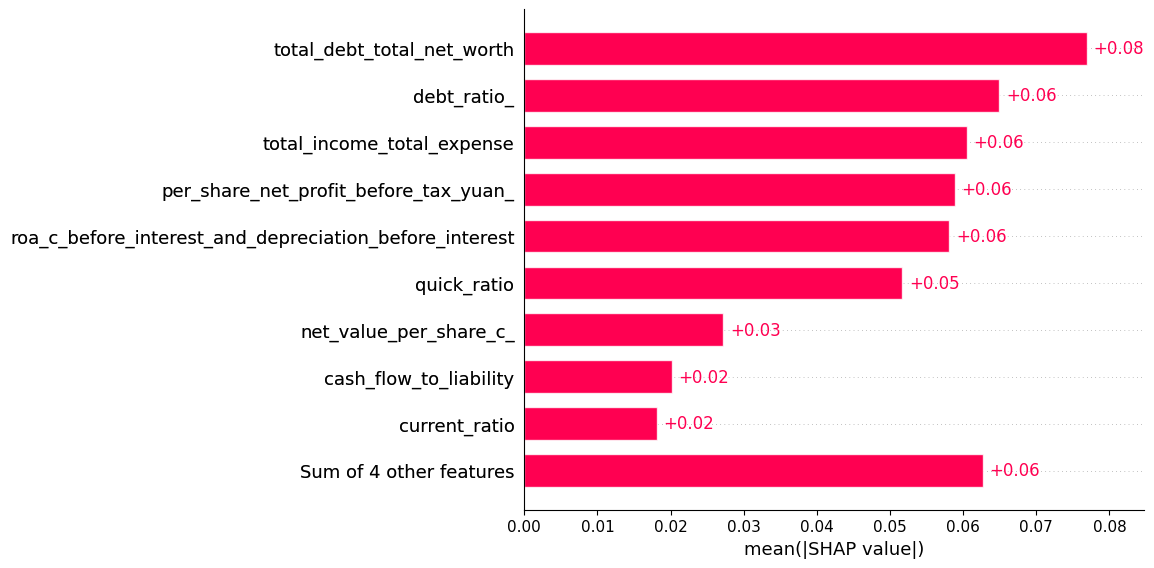

<Figure size 640x480 with 0 Axes>

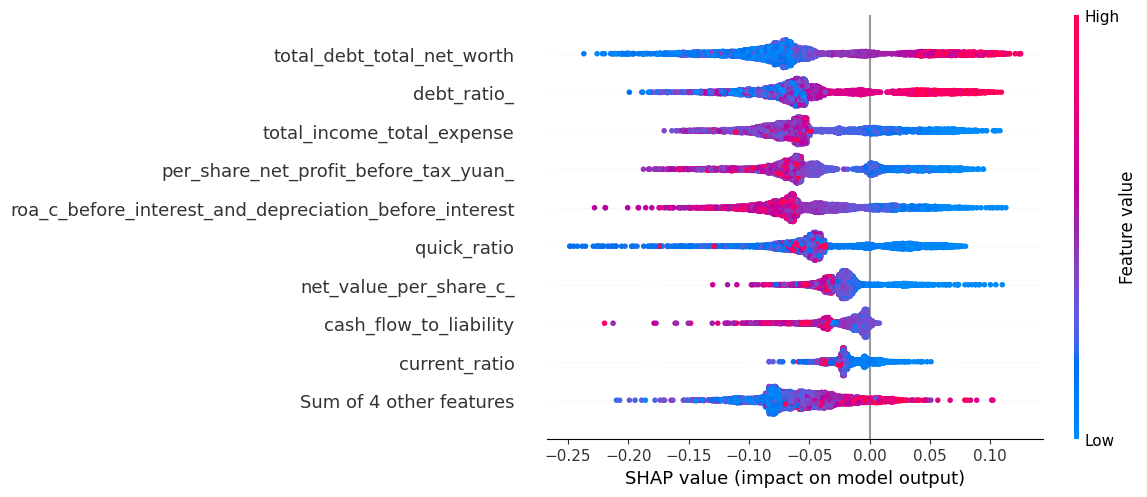

<Figure size 640x480 with 0 Axes>

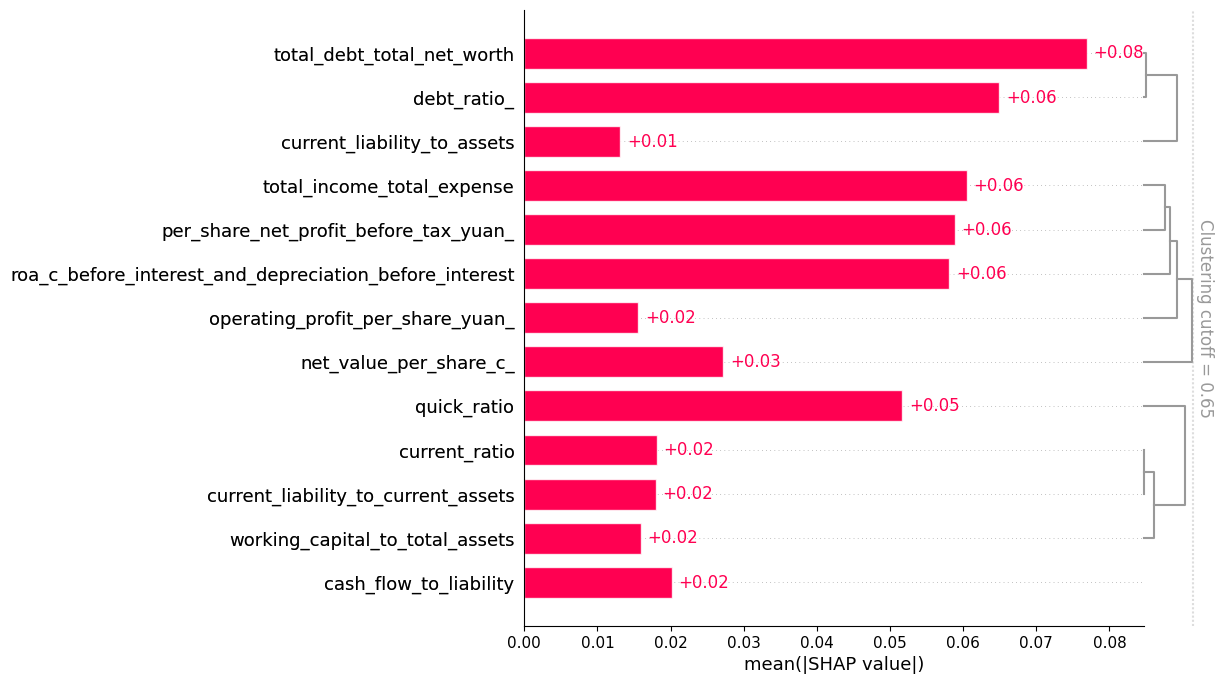

<Figure size 640x480 with 0 Axes>

In [21]:
# Fitting SHAP to Random Forest classifier
explainer = shap.TreeExplainer(model_shap)
shap_values = explainer.shap_values(X_train)

#Shap values for positive class
sv = shap_values[:,:,1]
sv_plot = sv.reshape(sv.shape[0], sv.shape[1])
base = explainer.expected_value[1]

# Build shap explanation object
expl = shap.Explanation(values=sv_plot, base_values=base, data=X_train, feature_names=list(X_train.columns))

# Plot bar chart, bee swarm chart
shap.plots.bar(expl, max_display=10)
plt.savefig(os.path.join(OUTPUT_DIR, "shap_expl_bar.png"), dpi=200)
plt.show()
plt.close()
shap.plots.beeswarm(expl, max_display=10)
plt.savefig(os.path.join(OUTPUT_DIR, "shap_expl_beeswarm.png"), dpi=200)
plt.show()
plt.close()

clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(expl, clustering=clustering, clustering_cutoff=.65, max_display=20)
plt.savefig(os.path.join(OUTPUT_DIR, "shap_clustering.png"), dpi=200)
plt.show()
plt.close()


Using SHAP analysis on the bankrupting class, we can determine the importance ranking of each feature in our current model from the bar plot, which plots each feature's absolute effect on classification. Using the beeswarm plot, we can also see what values are correlated with bankrupting vs. succeeding (further to right means the feature pushes classifier to predict bankruptcy).

Adding clustering to the analysis, we can also see how the features correlate with each other. This gives us a reduced feature set by grouping the impact of correlated features.

Selected SHAP features: ['debt_ratio_', 'per_share_net_profit_before_tax_yuan_', 'quick_ratio', 'roa_c_before_interest_and_depreciation_before_interest', 'total_debt_total_net_worth', 'total_income_total_expense']
ROC-AUC: 0.895684113865932
PR-AUC: 0.360632496585359
              precision    recall  f1-score   support

           0      0.986     0.955     0.970       990
           1      0.308     0.606     0.408        33

    accuracy                          0.943      1023
   macro avg      0.647     0.780     0.689      1023
weighted avg      0.965     0.943     0.952      1023



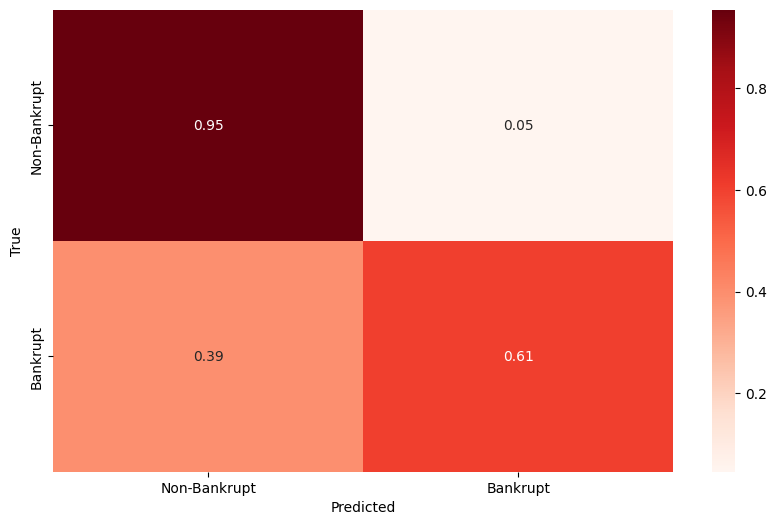

In [ ]:
# SHAP values (positive class)
mean_abs_shap = np.abs(sv).mean(axis=0)
mean_abs_shap = pd.Series(mean_abs_shap, index=X_train.columns)

# Pick features above threshold
threshold = 0.05
selected_features = mean_abs_shap[mean_abs_shap >= threshold].index.tolist()
print("Selected SHAP features:", selected_features)

# Reduced dataset
X_reduced_shap = X[selected_features]

X_train_shap, X_temp_shap, y_train_shap, y_temp_shap = train_test_split(
    X_reduced_shap, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

X_val_shap, X_test_shap, y_val_shap, y_test_shap = train_test_split(
    X_temp_shap, y_temp_shap,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp_shap
)

# Random forest
model = RandomForestClassifier(
    n_estimators=800,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)
model.fit(X_train_shap, y_train_shap)

# Threshold tuning
from utils.tune_threshold import tune_threshold
best_thr = tune_threshold(model, X_val_shap, y_val_shap)

# Test set predictions
y_proba_test = model.predict_proba(X_test_shap)[:, 1]
y_pred_best = (y_proba_test >= best_thr).astype(int)
y_pred_test = model.predict(X_test_shap)

# Metrics
print("ROC-AUC:", roc_auc_score(y_test_shap, y_proba_test))
print("PR-AUC:", average_precision_score(y_test_shap, y_proba_test))
print(classification_report(y_test_shap, y_pred_test, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test_shap, y_pred_test)
cm_rates = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

labels = ["Non-Bankrupt", "Bankrupt"]
plt.figure(figsize=(10,6))
sns.heatmap(cm_rates, annot=True, fmt=".2f", cmap="Reds",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(OUTPUT_DIR, "shap_confusion_matrix.png"), dpi=200)
plt.show()
plt.close()


Training a new model on just the most relevant features post-clustering (>=0.05 mean Shapley value) has only a slight reduction in precision and F1 score, while increasing recall on only 6 of the 13 features from the original dataset after VIF pruning.

We can use these particular metrics further downstream using monitoring rules and thresholds on these 6 particular features instead of the larger 13 or full ~90-dimensional data. We could even have users imput these values and return bankrupt/non-bankrupt predictions and warnings if they are close to the threshold.